# TM10007 Assignment template

In [6]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [44]:
import os
import pandas as pd
import numpy as np

data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 115
The number of columns: 494


In [56]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, data.index, test_size=0.20, random_state=42)


In [60]:
X_test.head()

print('Test set')
X_test.head()
print(f'The number of samples: {len(X_test.index)}')
print(f'The number of columns: {len(X_test.columns)}')

Test set
The number of samples: 23
The number of columns: 494


In [59]:
print('Training set')
X_train.head()
print(f'The number of samples: {len(X_train.index)}')
print(f'The number of columns: {len(X_train.columns)}')

Training set
The number of samples: 92
The number of columns: 494


,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,0.096312,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,0.030465,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,0.088020,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
Lipo-004_0,liposarcoma,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,0.123775,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
Lipo-005_0,lipoma,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,0.119364,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


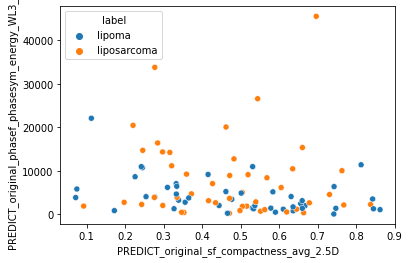

In [62]:
import seaborn

seaborn.scatterplot(x='PREDICT_original_sf_compactness_avg_2.5D', y='PREDICT_original_phasef_phasesym_energy_WL3_N5', hue='label', data=X_train)
data.head()


[9.99445139e-01 5.54657147e-04]
[1.24310470e+13 2.92846836e+11]


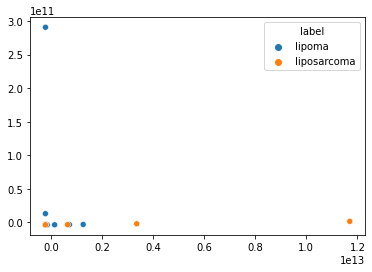

In [61]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_train.iloc[:,2:])
X_pca = pca.transform(X_train.iloc[:,2:])

seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_train['label'])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
